# Introduction to vector and raster analysis


This tutorial goes through a simplified workflow carried out in the [Urban Taxonomy using Hierarchical Morphotope Classification](https://urbantaxonomy.org/) project. The project aims to deliniate areas with similar morphological character - with similar configurations of streets, buildings and the space between them. The similarity reflect the land use use, planning paradigms and conditions under which they were constructed. The project covers every street and building in 6 contiguous European countries, ~120 million data points with 60 features each. This tutorial focuses on a small area, fewer features and simplified analysis to demonstrate the core concepts.

The buildings and street data used in the tutorial, comes from Openstreetmap. The data in the paper, comes from Overturemaps, which is a superset of Openstreetmap in which other data from satellite imagary and other providers is included. 

For a more detailed look into this type work visit the ``momepy`` documentaiton: https://docs.momepy.org/.

Or have a look at the full project page: https://urbantaxonomy.org/ and related GitHub repository: https://github.com/uscuni/urban_taxonomy/.

In [1]:
# import the requried libraries
import libpysal
import matplotlib.pyplot as plt
import momepy
import neatnet
import numpy as np
import osmnx
import pandas as pd

We will focus the analysis on Norwich.

In [2]:
place = "Znojmo, Czechia"
local_crs = 5514

## Buildings

One of the core elements of the analysis are detailed building footprints. To get the data, we first read all the possible information for buildings from Open Streetmap maps for our specified location. We then carry out some preprocessing to adress data inconsistencies and quality problems.

In [3]:
buildings = osmnx.features_from_place(place, tags={"building": True})
buildings.head()

geometry building bunker_type historic  \
element id                                                                    
node    3372076291  POINT (16.05376 48.84683)   bunker     pillbox      yes   
        3372076393  POINT (16.05581 48.84158)   bunker     pillbox      yes   
        3372076394  POINT (16.05867 48.83522)   bunker     pillbox      yes   
        3372076428  POINT (16.03949 48.85599)   bunker     pillbox      yes   
        3372076429  POINT (16.04133 48.85501)   bunker     pillbox      yes   

                   military            name ref:ropiky.net      source  \
element id                                                               
node    3372076291   bunker    7/I/10/A-120     1105625216  ropiky.net   
        3372076393   bunker  7/I/11/A-140 Z     1105625217  ropiky.net   
        3372076394   bunker    7/I/12/A-220     1105625218  ropiky.net   
        3372076428   bunker         7/I/8/E     1105625214  ropiky.net   
        3372076429   bunker         7/I/9/E     1105625215  ropiky.net   

                                                              website amenity  \
element id                                                                      
node    3372076291  https://ropiky.net/dbase_objekt.php?id=1105625216     NaN   
        3372076393  https://ropiky.net/dbase_objekt.php?id=1105625217     NaN   
        3372076394  https://ropiky.net/dbase_objekt.php?id=1105625218     NaN   
        3372076428  https://ropiky.net/dbase_objekt.php?id=1105625214     NaN   
        3372076429  https://ropiky.net/dbase_objekt.php?id=1105625215     NaN   

                    ... ref:koda name:signed branch monitoring:water_level  \
element id          ...                                                      
node    3372076291  ...      NaN         NaN    NaN                    NaN   
        3372076393  ...      NaN         NaN    NaN                    NaN   
        3372076394  ...      NaN         NaN    NaN                    NaN   
        3372076428  ...      NaN         NaN    NaN                    NaN   
        3372076429  ...      NaN         NaN    NaN                    NaN   

                   automated self_service shelter_type bridge:support  \
element id                                                              
node    3372076291       NaN          NaN          NaN            NaN   
        3372076393       NaN          NaN          NaN            NaN   
        3372076394       NaN          NaN          NaN            NaN   
        3372076428       NaN          NaN          NaN            NaN   
        3372076429       NaN          NaN          NaN            NaN   

                   construction type  
element id                            
node    3372076291          NaN  NaN  
        3372076393          NaN  NaN  
        3372076394          NaN  NaN  
        3372076428          NaN  NaN  
        3372076429          NaN  NaN  

[5 rows x 131 columns]

Next, we filter out unwated structures.

In [4]:
unwanted = [
    "garage",
    "garages",
    "shed",
    "bungalow",
    "roof",
    "parking",
    "kiosk",
    "hut",
    "pavilion",
    "greenhouse",
    "cabin",
    "toilets",
    "farm_auxiliary",
    "guardhouse",
    "bunker",
    "transportation",
    "ruins",
    "transformer_tower",
    "gatehouse",
    "hangar",
]

In [5]:
buildings = buildings[~buildings["building"].isin(unwanted)]
# drop barries such as city walls
buildings = buildings[~buildings.barrier.notna()]

In [6]:
buildings["building"].unique()

array(['chapel', 'yes', 'civic', 'residential', 'house', 'supermarket',
       'industrial', 'barn', 'hotel', 'church', 'school', 'apartments',
       'commercial', 'retail', 'warehouse', 'office', 'train_station',
       'sports_centre', 'brewery', 'detached', 'kindergarten', 'service',
       'mall', 'construction'], dtype=object)

Next, we filter out polygons that are not single structures.

In [7]:
buildings = buildings[buildings.geom_type == "Polygon"]

Lastly, we drop structures that have an area of less than $25m^2$. Before we do this, we have to reproject the data. 

In [8]:
buildings = buildings.set_crs(epsg=4326)

In [9]:
buildings = buildings[["geometry"]].to_crs(epsg=local_crs)
buildings = buildings[buildings.area > 25].reset_index(drop=True)
buildings.head()

,geometry
0,"POLYGON ((-643052.212 -1193474.914, -643069.77..."
1,"POLYGON ((-642796.708 -1193674.586, -642795.74..."
2,"POLYGON ((-642960.567 -1193475.288, -642969.02..."
3,"POLYGON ((-642973.521 -1193481.346, -642960.58..."
4,"POLYGON ((-642972.411 -1193762.425, -642979.76..."


### Streets

Similarly, the streets geometries also come from OpenStreetMap.

In [10]:
osm_graph = osmnx.graph_from_place(place, network_type="drive")
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)
streets = osmnx.graph_to_gdfs(
    osmnx.convert.to_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
).reset_index(drop=True)
streets.head()

,osmid,highway,maxspeed,name,ref,oneway,reversed,length,from,to,geometry,lanes,bridge,width,junction,tunnel,access
0,33733060,secondary,50,Přímětická,361,False,True,24.573585,639231391,74103628,"LINESTRING (-643229.639 -1192872.949, -643239....",NaN,NaN,NaN,NaN,NaN,NaN
1,33733060,secondary,50,Přímětická,361,False,False,60.345697,3775990798,74103628,"LINESTRING (-643236.395 -1192790.304, -643236....",NaN,NaN,NaN,NaN,NaN,NaN
2,50313252,residential,NaN,Raisova,NaN,True,False,74.762885,639231413,74103628,"LINESTRING (-643291.344 -1192797.012, -643288....",NaN,NaN,NaN,NaN,NaN,NaN
3,33733060,secondary,50,Přímětická,361,False,True,54.260241,74142638,639231391,"LINESTRING (-643205.434 -1192921.533, -643219....",NaN,NaN,NaN,NaN,NaN,NaN
4,50313241,residential,NaN,Mičurinova,NaN,True,False,104.235768,639231391,639231314,"LINESTRING (-643229.639 -1192872.949, -643233....",NaN,NaN,NaN,NaN,NaN,NaN


We carry out some preprocessing, similar to the buildings to drop unwated street segments such as tunnels, underground segments, or footpaths.

In [11]:
## service road removed
approved_roads = [
    "living_street",
    "motorway",
    "motorway_link",
    "pedestrian",
    "primary",
    "primary_link",
    "residential",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
    "trunk",
    "trunk_link",
    "unclassified",
]
streets = streets[streets["highway"].isin(approved_roads)]

The downloaded streets reflect the routing structure of the network, however we are more interested in its overall physical representation. For example dual-carriageways should be repreesented as one line, and round-abouts as an intersection of roads. We generate this representation from the routing represetntation using the open source Python package `neatnet`.

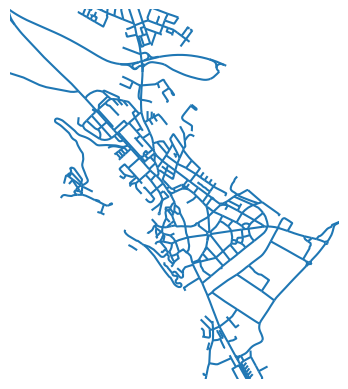

In [12]:
ax = streets.plot()
ax.set_xlim(-645000, -641000)
ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()

In [13]:
streets = streets.to_crs(epsg=local_crs)
streets = streets[["geometry", "highway"]].reset_index(drop=True)

## simplify
simplified = neatnet.neatify(
    streets,
    exclusion_mask=buildings.geometry,
    artifact_threshold_fallback=7,
)

/home/krasen/micromamba/envs/momepy_dev/lib/python3.13/site-packages/neatnet/simplify.py:801: UserWarning: No threshold for artifact detection found. Using the set fallback value of 7.
  artifacts, threshold = get_artifacts(


In [14]:
streets = simplified.copy()

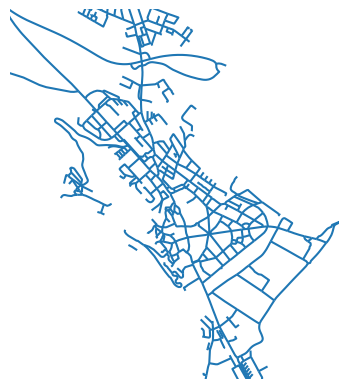

In [15]:
ax = streets.plot()
ax.set_xlim(-645000, -641000)
ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()

## Generated data

### Tessellation

We can generate a spatial unit using enclosed morphological tessellation, which aims to approximate plots and captures the area that is nearest to each building, bounded by specified enclosures such as streets, rivers, rail networks, etc. Its formal definition is :

> The portion of space that results from growing a morphological tessellation within an enclosure delineated by a series of natural or built barriers identified from the literature on urban form, function and perception.

Morpohological tessellation is a method to divide space into cells based on building footprints and Voronoi tessellation.

More information is available [here](https://www.sciencedirect.com/science/article/pii/S0197397522001382) .

To create the tessellation, first we create the enclosures based on the street network only. We use an adaptive limit to bound the enclosures, based on the distances to surrounding buildings. The aim is to avoid boundary effects at the edges of the study area. Tessellation cells with a negative index represent empty space with no associated buildings. The are still used in the analysis, to preserve contiguity and neighbourhood information.

In [16]:
limit = momepy.buffered_limit(buildings, "adaptive")
enclosures = momepy.enclosures(streets, limit=limit, clip=True)

<Axes: >

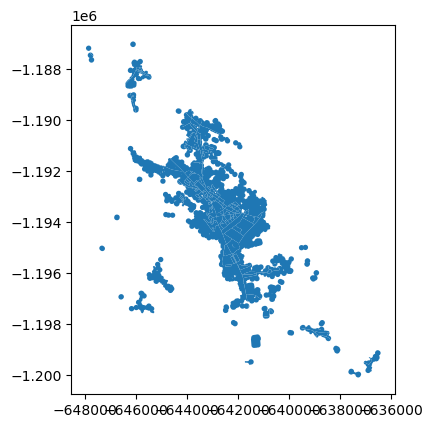

In [17]:
enclosures.plot()

In [18]:
tessellation = momepy.enclosed_tessellation(buildings, enclosures)

In [19]:
tessellation[tessellation.index > -1].shape, buildings.shape

((8563, 2), (8562, 1))

OpenStreetMap data are often problematic due to low quality of some polygons. We get a mismatch between the length of buildings and the length of polygons. Therefore, we carry out some ETC post processing:
1. We drop all buildings that collapse into multiple parts during the processing
2. We redo the tessellation
3. We process the multipolygon tessellation geometries by combining split ETCs and droping any empty space belonging to a particular building 

In [20]:
collapsed, multipolygons = momepy.verify_tessellation(tessellation, buildings)

/tmp/ipykernel_38747/3617767949.py:1: UserWarning: Tessellation does not fully match buildings. 0 element(s) disappeared during generation. Index of the affected elements: Index([], dtype='int64').
  collapsed, multipolygons = momepy.verify_tessellation(tessellation, buildings)
/tmp/ipykernel_38747/3617767949.py:1: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. Index of affected elements: [5262, 40, 1089, 1813, 2041, 3153, 3160, 3174, 3192, 3230, 3240, 3993, 4070, 4079, 5056, 8029, 1752, 7387, 5339, 1265, 1653, 1794, 2204, 2209, 2223, 2347, 2369, 2429, 2439, 2455, 2499, 2513, 2530, 2556, 3893, 3909, 3920, 5111, 5122, 5256, 6641, 6666, 6687, 4661, 5421, 5423, 5424, 7586, 3003, 67, 177, 1922, 6972, 7304, 8311, 5429, 5515, 6270, 6278, 6289, 6291, 6573, 7390, 8073, 8168, 8266, 8514, 5984, 6227, 6142, 6021, 7194, 7212, 7230, 7261, 8112, 418, 6218, 7451, 4905, 5008, 5026, 7560, 2873, 2887, 4917, 4969, 4298, 4142, 4170, 4217].
  collapsed, multipo

In [21]:
buildings = buildings.drop(collapsed).reset_index(drop=True)
limit = momepy.buffered_limit(buildings, "adaptive")
enclosures = momepy.enclosures(streets, limit=limit, clip=True)

tessellation = momepy.enclosed_tessellation(buildings, enclosures)

In [22]:
tessellation[tessellation.index > -1].shape[0], buildings.shape[0]

(8563, 8562)

In [23]:
def postprocess_tessellation(tessellation):
    # deal with split buildings
    tessellation = tessellation.dissolve(by=tessellation.index.values)

    # drop empty spaces with no buildings and a positive index,
    # leave negatives in the geodataframe
    tessellation = tessellation.explode()
    inp, res = buildings.geometry.centroid.sindex.query(tessellation.geometry)
    to_keep = np.append(
        np.unique(inp), np.where(tessellation.index.values < 0)[0]
    )
    tessellation = tessellation.iloc[to_keep]

    ### drop any remaining duplicates
    ## sometimes -1s have multiple tesselation cells
    tessellation = tessellation[~tessellation.index.duplicated()].sort_index()
    return tessellation

In [24]:
tessellation = postprocess_tessellation(tessellation)

In [25]:
tessellation[tessellation.index > -1].shape[0], buildings.shape[0]

(8562, 8562)

### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [26]:
buildings["street_index"] = momepy.get_nearest_street(
    buildings, streets, max_distance=50
)
buildings

,geometry,street_index
0,"POLYGON ((-643052.212 -1193474.914, -643069.77...",465.0
1,"POLYGON ((-642796.708 -1193674.586, -642795.74...",352.0
2,"POLYGON ((-642960.567 -1193475.288, -642969.02...",473.0
3,"POLYGON ((-642973.521 -1193481.346, -642960.58...",473.0
4,"POLYGON ((-642972.411 -1193762.425, -642979.76...",362.0
...,...,...
8557,"POLYGON ((-642036.997 -1193844.433, -642056.10...",430.0
8558,"POLYGON ((-645024.109 -1195457.488, -645020.32...",NaN
8559,"POLYGON ((-643348.713 -1194485, -643354.305 -1...",NaN
8560,"POLYGON ((-643355.583 -1194511.117, -643350.49...",NaN


Aattach the network index to the tessellation as well.

In [27]:
tessellation["street_index"] = buildings["street_index"]

## Measure

Measure individual morphometric characters. For details see the User Guide and the API reference.

### Dimensions

In [28]:
buildings["building_area"] = buildings.area
tessellation["tess_area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [29]:
buildings["eri"] = momepy.equivalent_rectangular_index(buildings)
buildings["elongation"] = momepy.elongation(buildings)
tessellation["convexity"] = momepy.convexity(tessellation)
streets["linearity"] = momepy.linearity(streets)

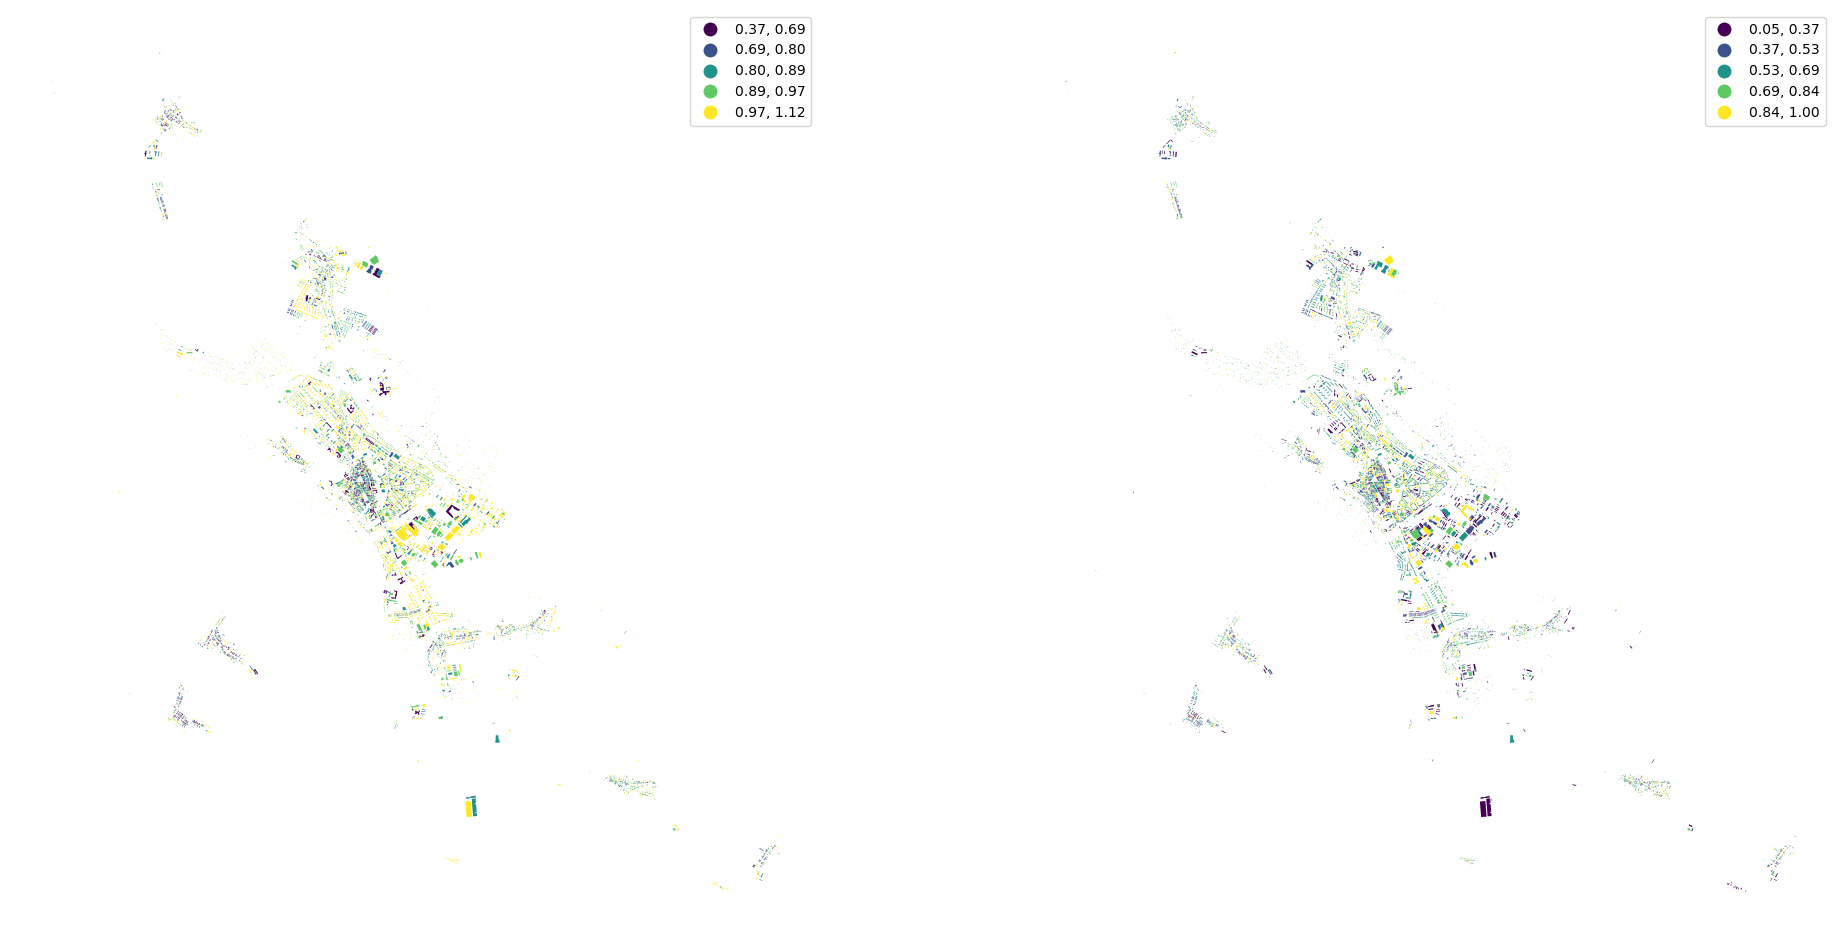

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

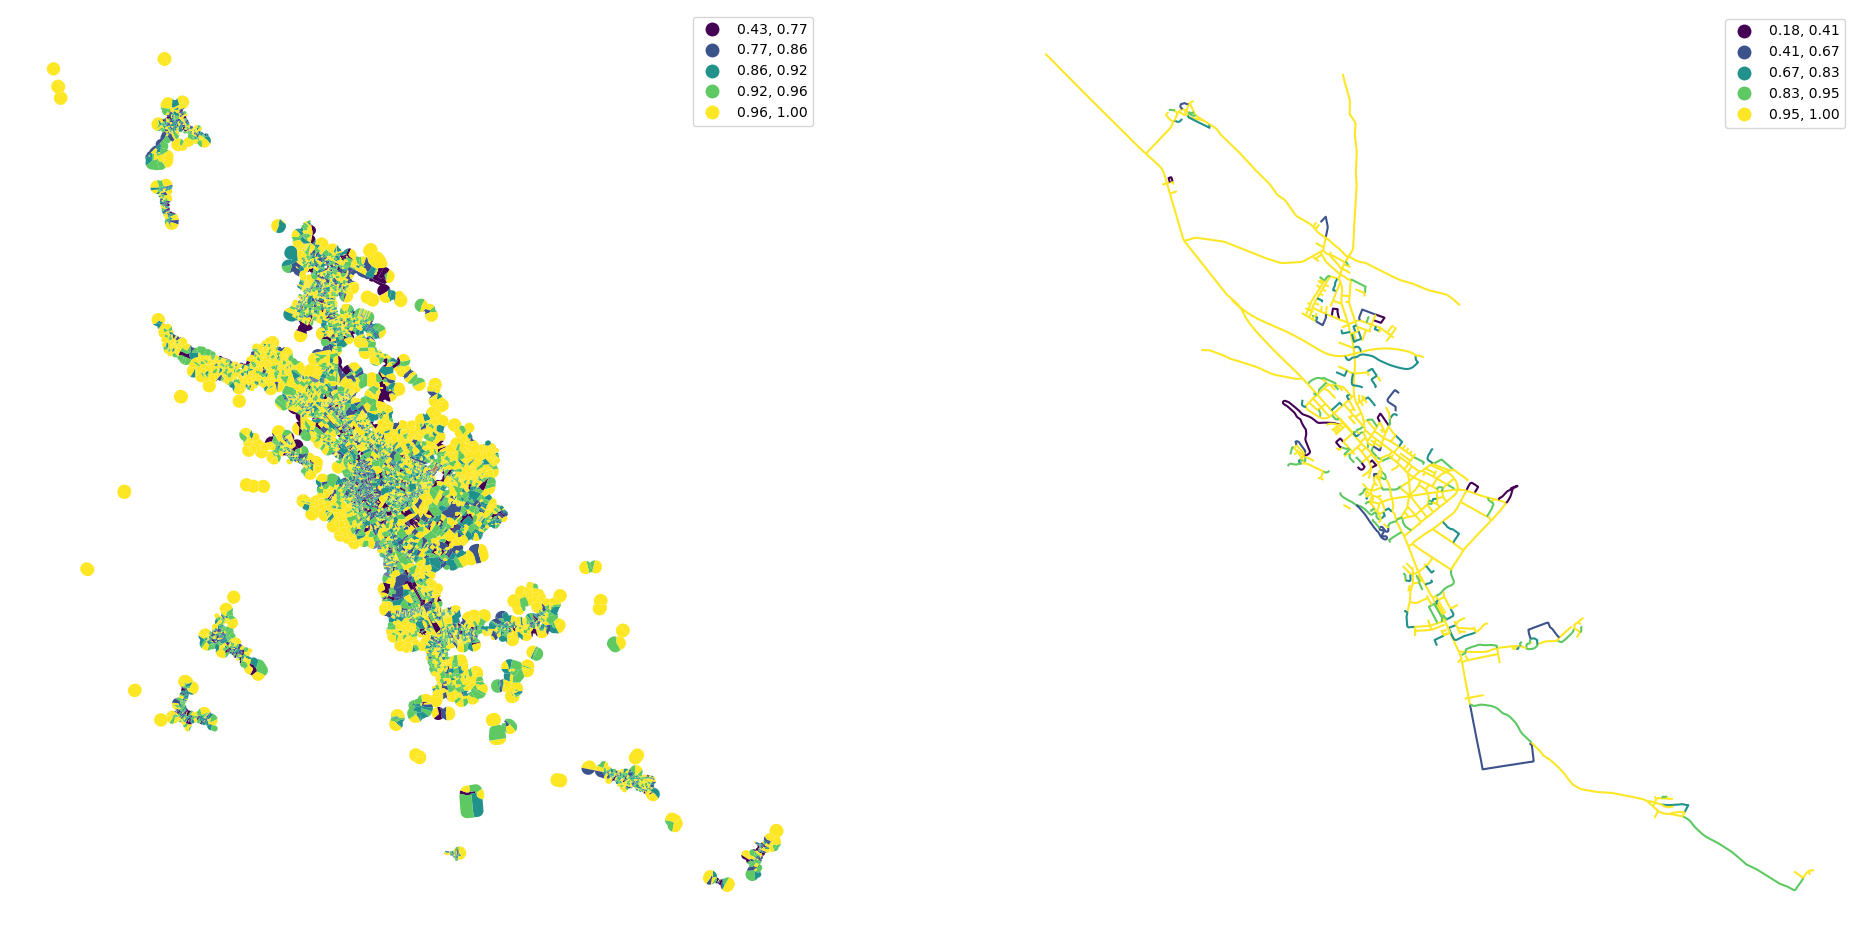

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

### Spatial distribution

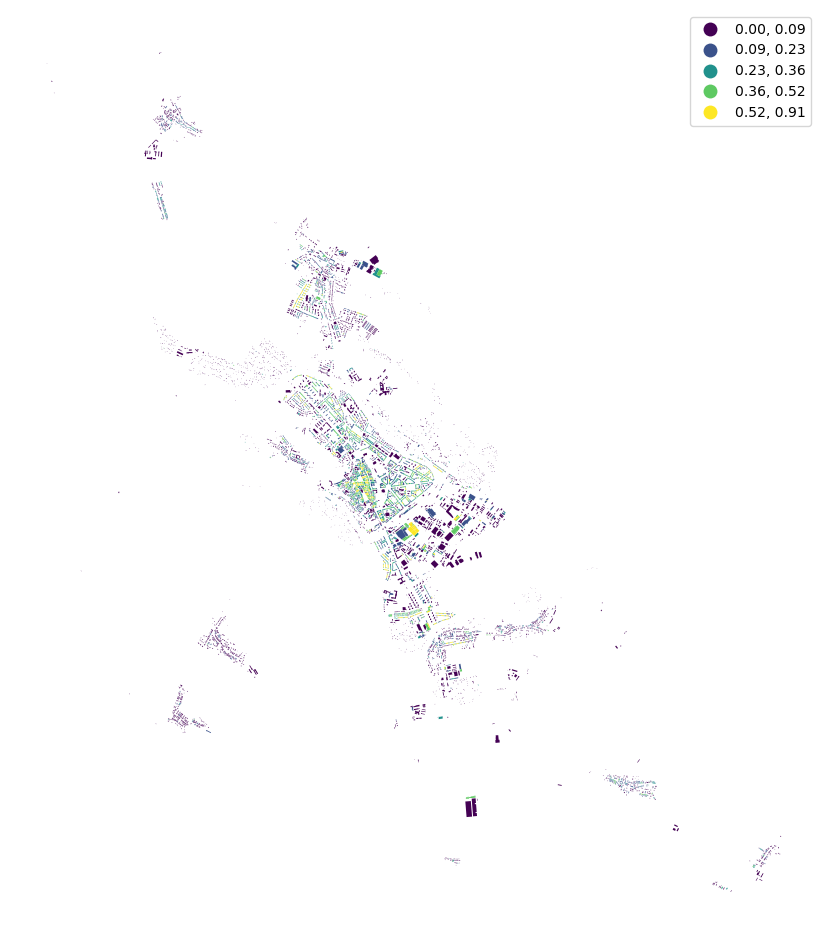

In [32]:
buildings["shared_walls"] = momepy.shared_walls(buildings) / buildings.length
buildings.plot(
    "shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True
).set_axis_off()

Generate spatial graph using `libpysal`.

In [33]:
queen_1 = libpysal.graph.Graph.build_contiguity(tessellation, rook=False)

In [34]:
queen_1

<Graph of 8585 nodes and 42490 nonzero edges indexed by
 [-23, -22, -21, -20, -19, ...]>

Due to floating point errors and data quality there are coverage issues with the polygons. Buildings that should have shared walls overlap .001 cm or overlap only at the corners, or have a miniscule distance between them, for example. The same is true for tessellation cells. To account for this we can use fuzzy contiguity when building a graph of spatial relationships.

In [35]:
queen_1 = libpysal.graph.Graph.build_fuzzy_contiguity(tessellation, buffer=0.5)
queen_1

<Graph of 8585 nodes and 50022 nonzero edges indexed by
 [-23, -22, -21, -20, -19, ...]>

In [36]:
tessellation["neighbors"] = momepy.neighbors(
    tessellation, queen_1, weighted=True
)
tessellation["covered_area"] = queen_1.describe(tessellation.area)["sum"]

In [37]:
# limit graph only to buildings
buildings["neighbor_distance"] = momepy.neighbor_distance(
    buildings, queen_1.subgraph(queen_1.unique_ids[queen_1.unique_ids > -1])
)

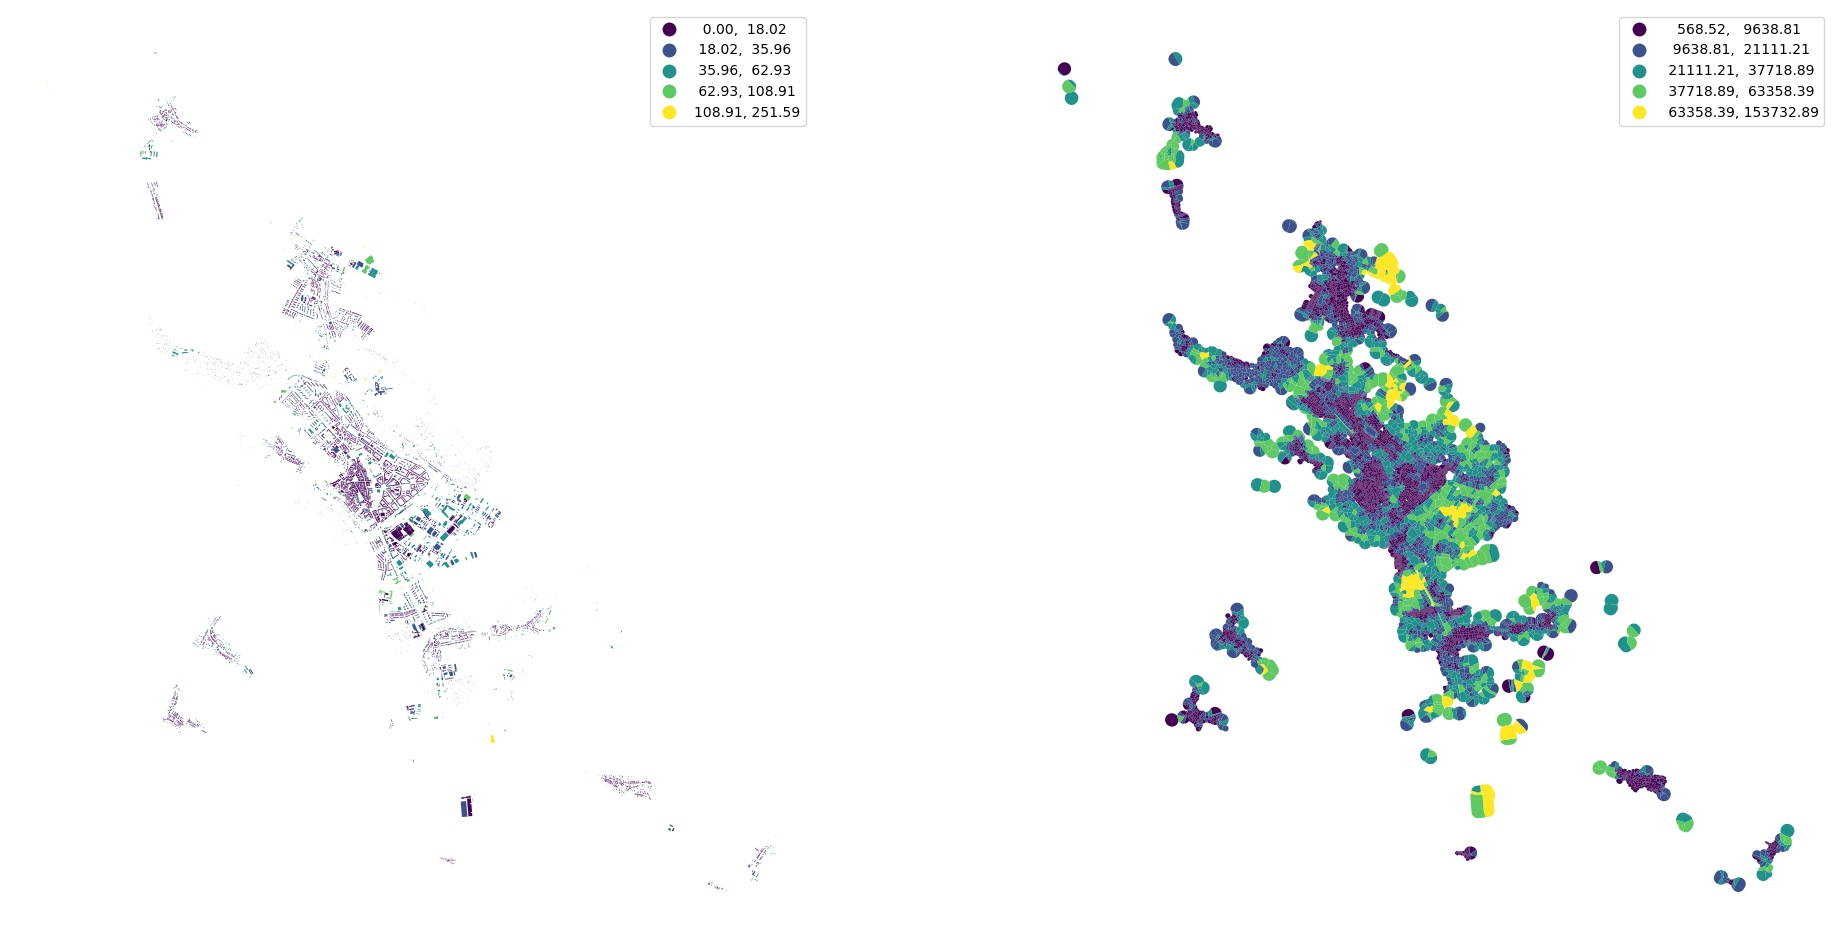

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot(
    "neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True
)
tessellation.plot(
    "covered_area", ax=ax[1], scheme="natural_breaks", legend=True
)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [39]:
# here we have to get a higher order graph then subset,
# in order to preserve contiguity infromation across the empty space
queen_3 = queen_1.higher_order(3)

buildings["interbuilding_distance"] = momepy.mean_interbuilding_distance(
    buildings,
    queen_1.subgraph(queen_1.unique_ids[queen_1.unique_ids > -1]),
    queen_3.subgraph(queen_3.unique_ids[queen_3.unique_ids > -1]),
)

/home/krasen/micromamba/envs/momepy_dev/lib/python3.13/site-packages/momepy/functional/_distribution.py:375: RuntimeWarning: invalid value encountered in scalar divide
  mean_distances[i] = sub_matrix.sum() / sub_matrix.nnz


In [40]:
buildings_q1 = libpysal.graph.Graph.build_contiguity(buildings, rook=False)
buildings["adjacency"] = momepy.building_adjacency(
    buildings_q1, queen_3.subgraph(queen_3.unique_ids[queen_3.unique_ids > -1])
)

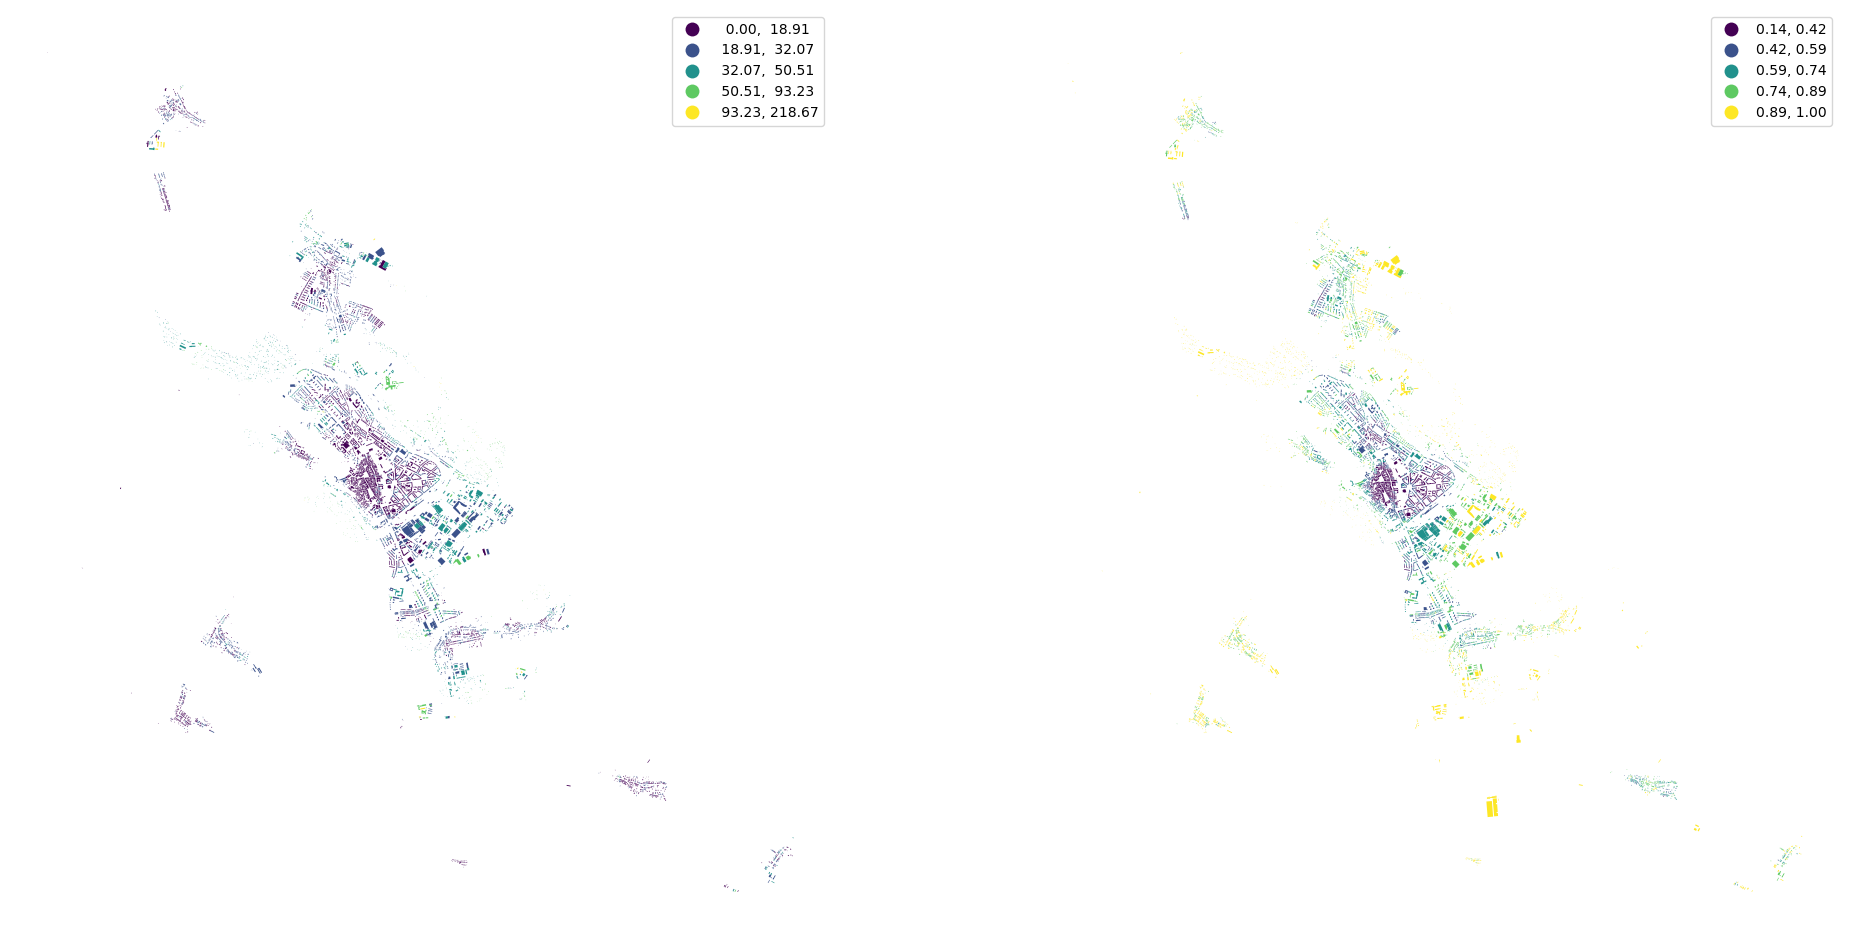

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot(
    "interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True
)
buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [42]:
profile = momepy.street_profile(streets, buildings)
streets[profile.columns] = profile

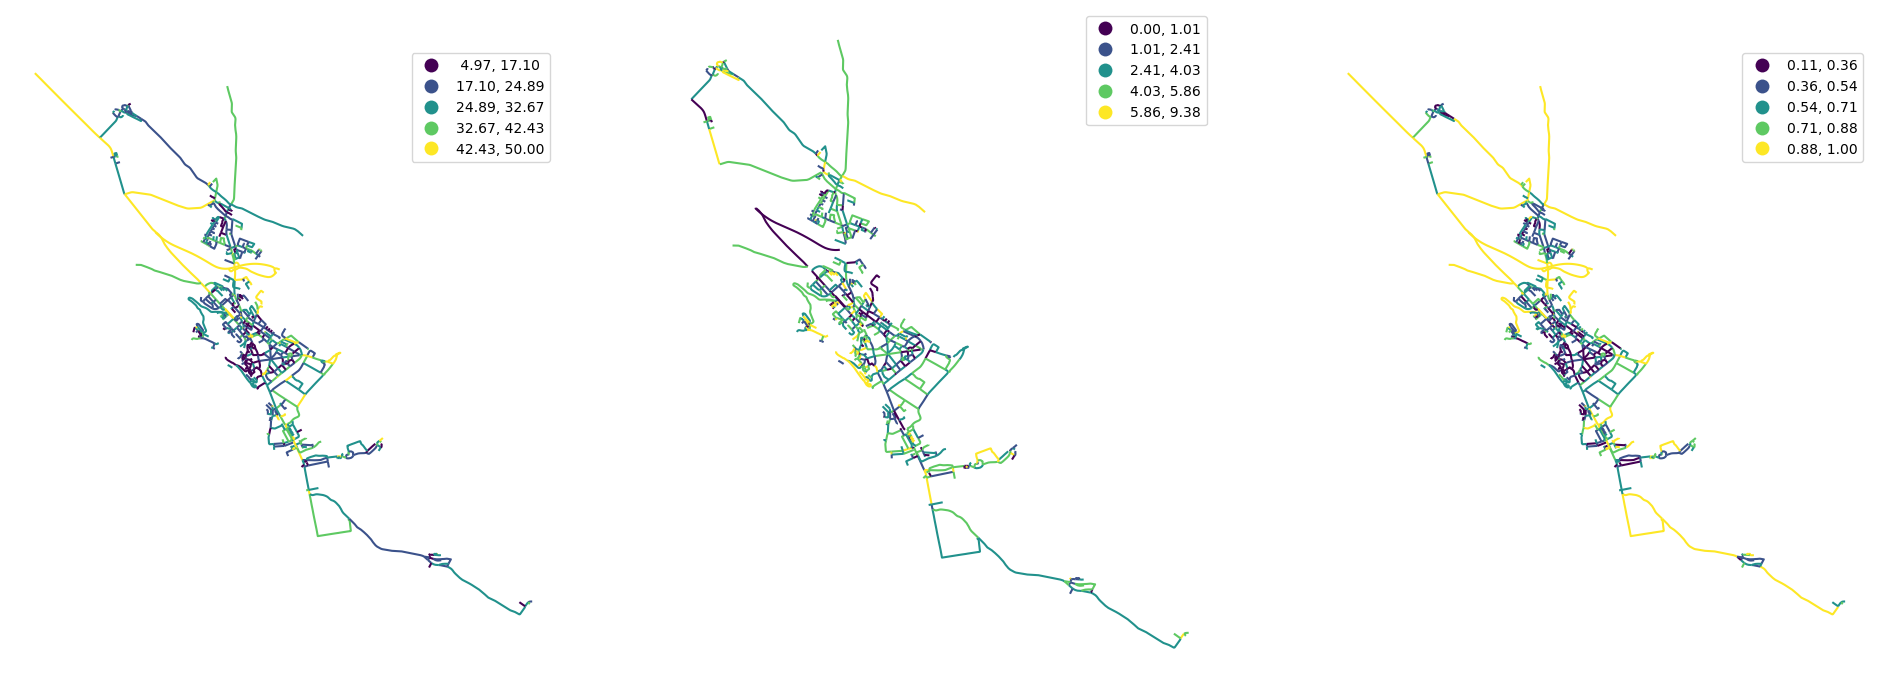

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

### Intensity

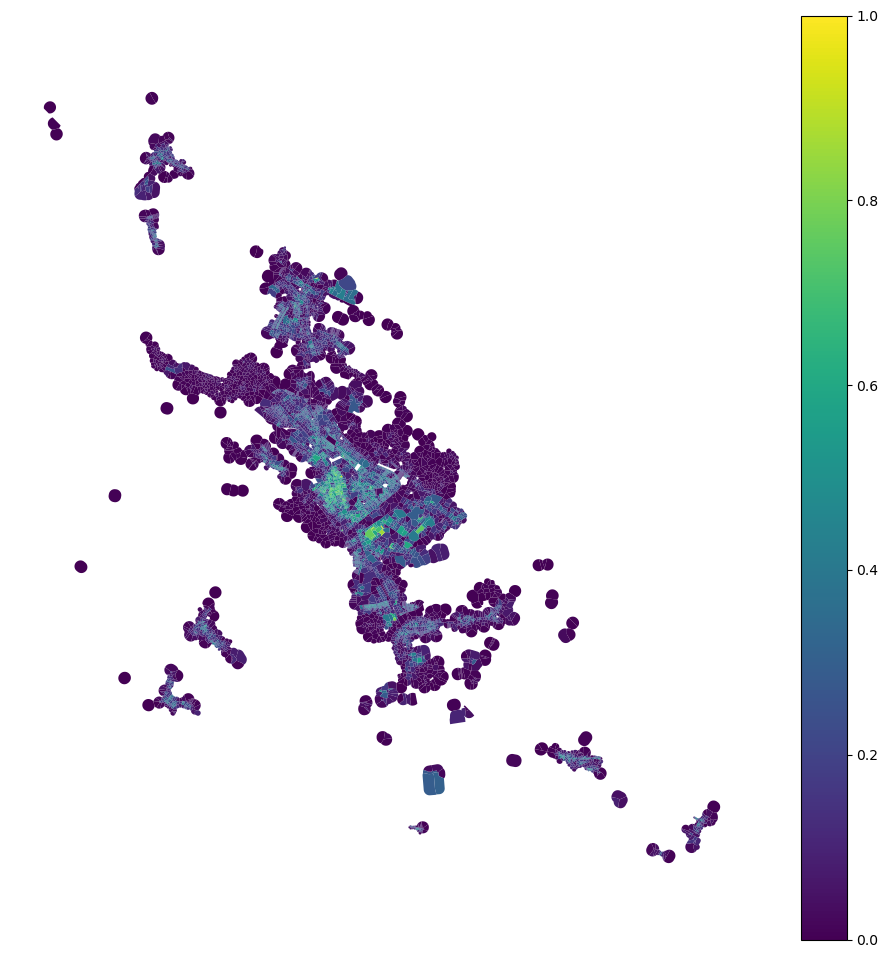

In [44]:
tessellation["car"] = buildings.area / tessellation.area
tessellation.plot(
    "car", figsize=(12, 12), vmin=0, vmax=1, legend=True
).set_axis_off()

### Connectivity

In [45]:
graph = momepy.gdf_to_nx(streets)
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")
nodes, edges = momepy.nx_to_gdf(graph)

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

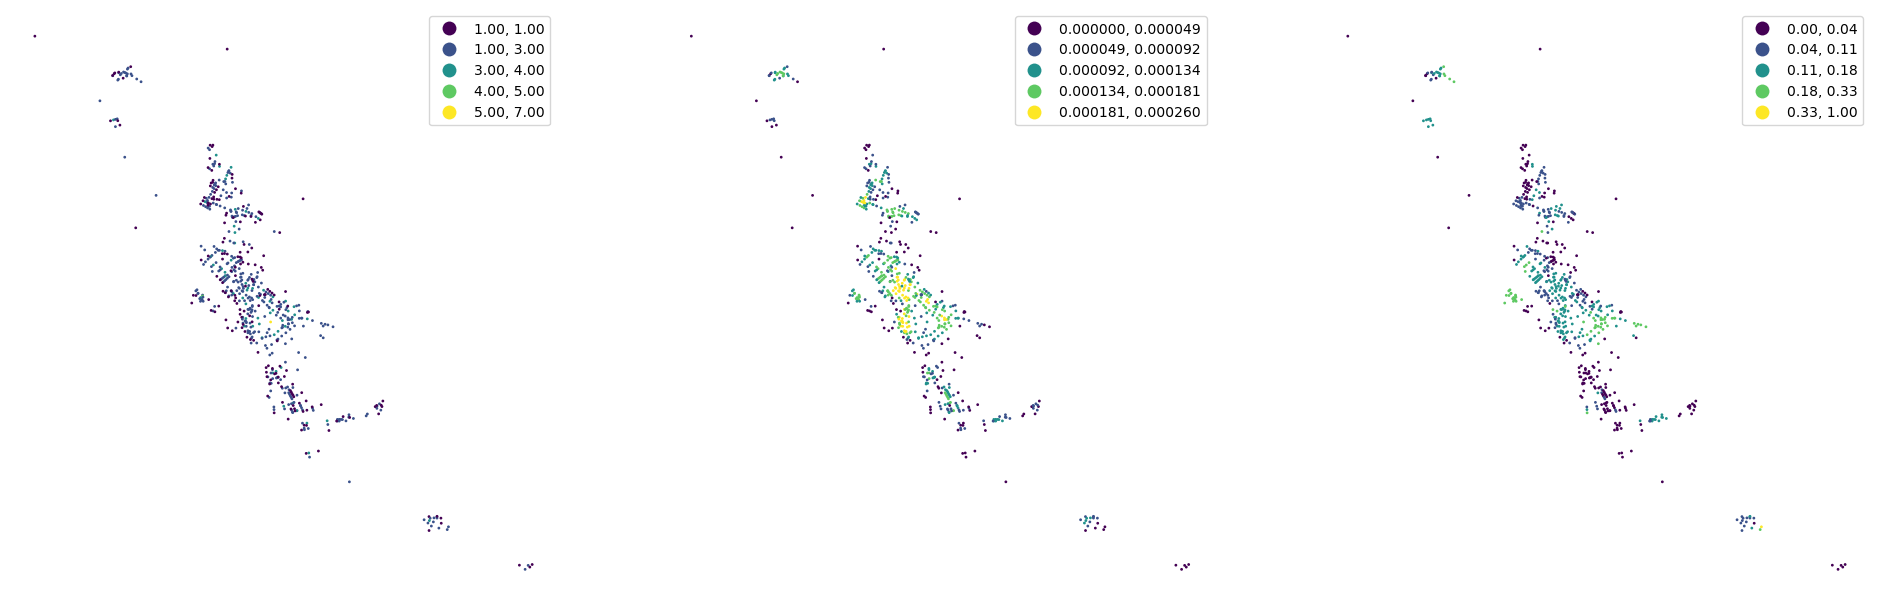

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot(
    "degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1
)
nodes.plot(
    "closeness",
    ax=ax[1],
    scheme="natural_breaks",
    legend=True,
    markersize=1,
    legend_kwds={"fmt": "{:.6f}"},
)
nodes.plot(
    "meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1
)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

In [47]:
buildings["edge_index"] = momepy.get_nearest_street(buildings, edges)
buildings["node_index"] = momepy.get_nearest_node(
    buildings, nodes, edges, buildings["edge_index"]
)

Link all data together (to tessellation cells or buildings).

In [48]:
tessellation.head()

,enclosure_index,geometry,street_index,tess_area,convexity,neighbors,covered_area,car
-23,8,"POLYGON ((-643057.721 -1193228.246, -643061.59...",NaN,3502.839560,0.716104,0.021276,29055.685628,NaN
-22,44,"POLYGON ((-643396.887 -1191632.126, -643398.07...",NaN,6640.645524,0.932859,0.017464,28114.561156,NaN
-21,45,"POLYGON ((-643396.887 -1191632.126, -643395.98...",NaN,7552.919235,0.928678,0.024104,59278.471963,NaN
-20,46,"POLYGON ((-643391.592 -1191685.21, -643395.989...",NaN,2526.696833,0.996708,0.023384,46047.969000,NaN
-19,50,"POLYGON ((-642882.387 -1191793.377, -642854.29...",NaN,1932.297131,0.921267,0.003633,17069.871514,NaN


In [49]:
buildings.head()

,geometry,street_index,building_area,eri,elongation,shared_walls,neighbor_distance,interbuilding_distance,adjacency,edge_index,node_index
0,"POLYGON ((-643052.212 -1193474.914, -643069.77...",465.0,770.419570,0.742491,0.971708,0.000000,18.909292,6.795246,0.341463,183.0,391.0
1,"POLYGON ((-642796.708 -1193674.586, -642795.74...",352.0,1830.570622,0.544350,0.850052,0.170633,17.551139,12.633699,0.333333,73.0,85.0
2,"POLYGON ((-642960.567 -1193475.288, -642969.02...",473.0,532.527489,0.646696,0.629206,0.499747,1.894416,8.104306,0.315789,543.0,318.0
3,"POLYGON ((-642973.521 -1193481.346, -642960.58...",473.0,765.313279,0.630997,0.734407,0.301092,10.873376,5.020349,0.232558,543.0,395.0
4,"POLYGON ((-642972.411 -1193762.425, -642979.76...",362.0,831.023404,0.618086,0.273948,0.444967,4.196437,7.373428,0.268293,274.0,323.0


In [50]:
tessellation[buildings.columns.drop(["geometry", "street_index"])] = (
    buildings.drop(columns=["geometry", "street_index"])
)
merged = tessellation.merge(
    edges.drop(columns="geometry"),
    left_on="edge_index",
    right_index=True,
    how="left",
)
merged = merged.merge(
    nodes.drop(columns="geometry"),
    left_on="node_index",
    right_index=True,
    how="left",
)

In [51]:
merged.columns

Index(['enclosure_index', 'geometry', 'street_index', 'tess_area', 'convexity',
       'neighbors', 'covered_area', 'car', 'building_area', 'eri',
       'elongation', 'shared_walls', 'neighbor_distance',
       'interbuilding_distance', 'adjacency', 'edge_index', 'node_index',
       '_status', 'highway', 'length', 'linearity', 'width', 'openness',
       'width_deviation', 'mm_len', 'node_start', 'node_end', 'x', 'y',
       'degree', 'closeness', 'meshedness', 'nodeID'],
      dtype='object')

In [52]:
attr_columns = merged.columns.drop(
    [
        "enclosure_index",
        "street_index",
        "node_index",
        "edge_index",
        "nodeID",
        "mm_len",
        "node_start",
        "node_end",
        "geometry",
        "x",
        "y",
        "_status",
        "highway",
    ]
)

In [54]:
merged[attr_columns]

,tess_area,convexity,neighbors,covered_area,car,building_area,eri,elongation,shared_walls,neighbor_distance,interbuilding_distance,adjacency,length,linearity,width,openness,width_deviation,degree,closeness,meshedness
-23,3502.839560,0.716104,0.021276,29055.685628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-22,6640.645524,0.932859,0.017464,28114.561156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-21,7552.919235,0.928678,0.024104,59278.471963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-20,2526.696833,0.996708,0.023384,46047.969000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-19,1932.297131,0.921267,0.003633,17069.871514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8557,11265.954675,0.991688,0.035367,52146.850578,0.044327,499.381853,1.000070,0.898302,0.000000,69.068293,23.307679,0.500000,130.639175,1.000000,23.263158,0.500000,1.677496,3.0,0.000137,0.200000
8558,33968.039270,1.000000,0.000000,NaN,0.001194,40.555787,1.000061,0.806045,0.000000,NaN,0.000000,1.000000,123.601753,0.998809,32.140224,0.666667,1.441538,1.0,0.000012,-0.000000
8559,8818.001454,0.995051,0.015923,54927.241978,0.003681,32.462300,1.000637,0.668577,0.000000,88.553304,65.804371,1.000000,960.344502,0.508046,25.233390,0.707692,7.941148,3.0,0.000022,0.000000
8560,7884.018313,0.987154,0.005451,13315.955122,0.003548,27.974246,1.000303,0.701125,0.000000,22.173787,77.470752,1.000000,960.344502,0.508046,25.233390,0.707692,7.941148,3.0,0.000022,0.000000


## Unsupervised machine learning

## Morphotopes

The first step in the analysis is to group our elements into morphotopes using the `SA3` algorithm. Morphotopes are defined as :

> “the smallest urban locality obtaining distinctive character among their neighbours from their particular combination of constituent morphological elements.”

We do this to create contiguous units which can act as the base of the hierarchical analysis. 

This is also an example of the second way of using spatial relationships - directly embeding them in the algorithm.

In [55]:
from sklearn.preprocessing import StandardScaler
from spopt.region import SA3

In [56]:
# limit the analysis to only the tessellation cells with buildings in them
# and only to the selected columns
training_data = merged.loc[merged.index > -1, attr_columns]

# standardise data and fill NAs with 0
res = StandardScaler().fit_transform(training_data)
standardised_data = pd.DataFrame(res, columns=attr_columns).fillna(0)

In [57]:
clusterer = SA3(
    standardised_data,
    queen_1.subgraph(queen_1.unique_ids[queen_1.unique_ids > -1]),
    standardised_data.columns,
    min_cluster_size=75,
    extraction="leaf",
    linkage="ward",
)
clusterer.solve()
clusterer.labels_.value_counts()

-1     1231
 43     406
 36     324
 18     273
 31     257
 27     237
 19     222
 10     211
 34     210
 41     207
 40     188
 22     185
 4      179
 0      174
 3      167
 28     165
 26     162
 7      161
 8      151
 12     146
 20     146
 30     139
 14     138
 2      133
 35     127
 5      124
 32     124
 37     123
 42     118
 33     115
 15     114
 25     114
 38     109
 39     102
 1      102
 48     100
 21      99
 45      98
 16      98
 11      97
 24      90
 23      89
 9       87
 50      87
 6       85
 46      82
 47      82
 29      79
 49      78
 17      76
 13      76
 44      75
Name: count, dtype: int64

This is what an example morphotope looks like. In this case it is the industrual area of the town.

<Axes: >

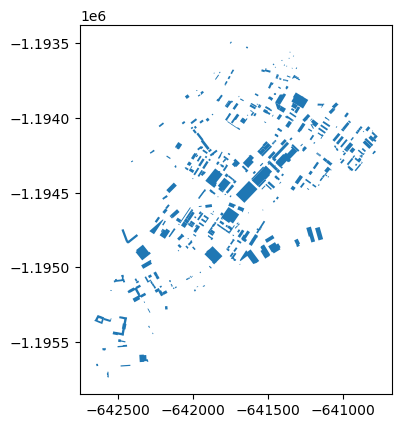

In [58]:
buildings[clusterer.labels_ == clusterer.labels_.value_counts().index[1]].plot()

## Clustering

Now we can use the morphotopes to create a hierarchical typology of urban structure. To do this we use simple dendrogram clustering models.

In [59]:
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

In [60]:
morph_clusters = clusterer.labels_

In [61]:
grouped_data = standardised_data.groupby(morph_clusters).median()
if -1 in grouped_data.index:
    grouped_data = grouped_data.iloc[1:]

In [62]:
linkage_matrix = linkage(grouped_data, method="ward")

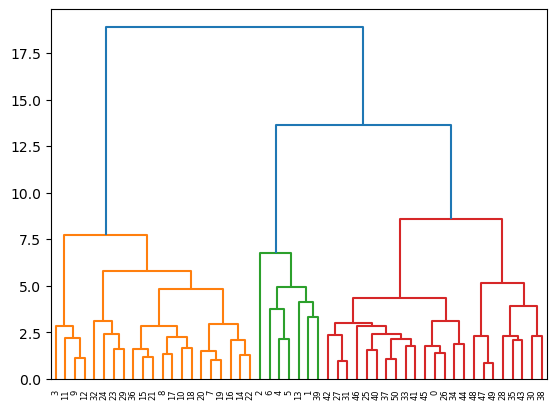

In [63]:
_ = dendrogram(linkage_matrix)

In [64]:
morphotope_labels = fcluster(linkage_matrix, t=4, criterion="distance")
pd.Series(morphotope_labels).value_counts()

9     10
3      7
4      6
10     5
12     5
2      4
1      4
5      3
11     3
6      2
8      1
7      1
Name: count, dtype: int64

In [65]:
final_labels = pd.Series(morph_clusters).replace(
    pd.Series(morphotope_labels, index=grouped_data.index).to_dict()
)
final_labels.value_counts()

 9     1528
 3     1248
-1     1231
 4      950
 12     946
 10     719
 1      497
 5      388
 2      382
 11     260
 6      204
 8      133
 7       76
Name: count, dtype: int64

The SA3 algorithm assigns buildings that are not morphologically similar to another group, or are not numerous enough to form a morphotope to a noise cluster. One way to deal with this noise cluster is to assign each tessellation cell in to its nearest cluster. We do this next.

In [66]:
from sklearn.neighbors import KDTree

cluster_centres = standardised_data.groupby(final_labels).median().iloc[1:]
tree = KDTree(cluster_centres)
dists, idxs = tree.query(standardised_data[final_labels == -1], k=1)
final_labels[final_labels == -1] = idxs[:, 0] + 1

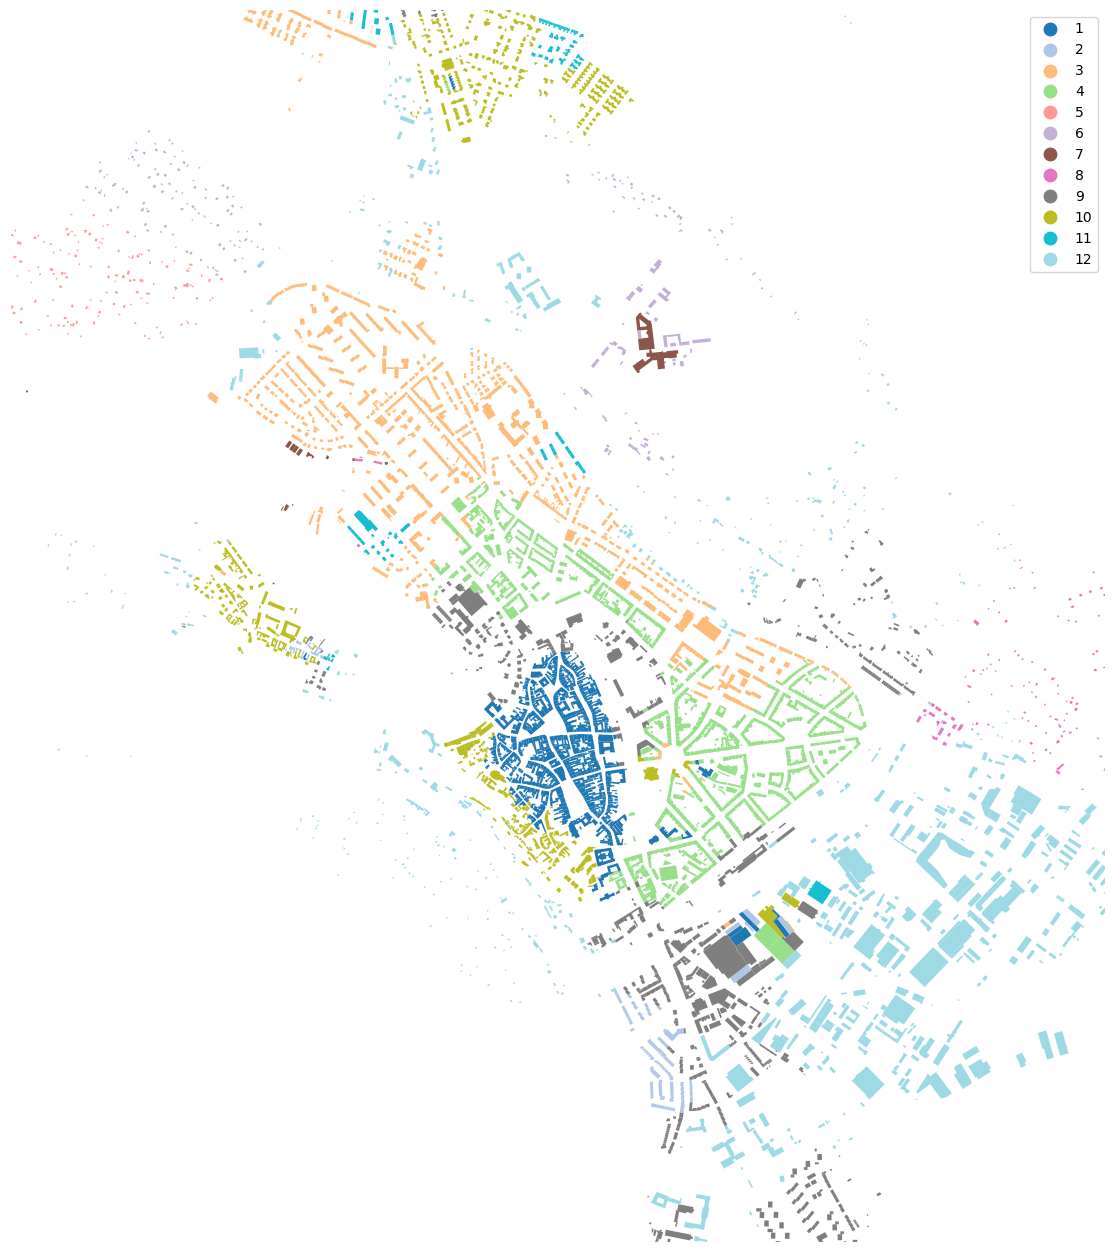

In [67]:
ax = buildings.plot(
    final_labels, categorical=True, figsize=(16, 16), legend=True, cmap="tab20"
)
ax.set_xlim(-645000, -641000)
ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()

In [68]:
merged[attr_columns].groupby(final_labels).median().T.iloc[
    :,
].style.background_gradient(axis=1)

,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000
tess_area,364.302886,335.873254,623.814081,471.643660,2128.023450,2476.735007,6088.785121,2442.921833,963.048514,729.793538,1119.678355,3089.666062
convexity,0.899078,0.936518,0.959121,0.943216,0.968898,0.972693,0.968938,0.976621,0.950506,0.932645,0.939124,0.968197
neighbors,0.067777,0.059779,0.049411,0.058476,0.028087,0.026078,0.014544,0.026491,0.041091,0.049832,0.037325,0.024207
covered_area,3543.274615,3450.755261,6568.310127,4860.609117,14627.562156,16535.763883,29138.965580,18458.375986,8722.003660,6084.212507,8415.270879,23726.263276
car,0.566142,0.300250,0.209286,0.358820,0.033060,0.027776,0.023986,0.021220,0.160067,0.197292,0.154912,0.053498
building_area,188.691836,93.175927,113.895621,154.476607,61.232709,64.327736,78.138219,50.446713,128.028418,133.401974,151.294301,112.797226
eri,0.891895,0.996259,0.984090,0.973307,0.999637,0.999828,0.999549,0.998817,0.976702,0.920829,0.945156,0.997520
elongation,0.593424,0.568922,0.685773,0.741457,0.719212,0.738641,0.653867,0.770940,0.669523,0.688413,0.609538,0.655470
shared_walls,0.385129,0.363414,0.238916,0.358396,0.000000,0.000000,0.000000,0.000000,0.096165,0.105057,0.000000,0.000000
neighbor_distance,5.420467,11.860520,17.763131,11.927517,35.533127,41.154290,43.625147,44.554237,19.724862,15.328879,17.731307,39.271890
